### Investigate the relationship between option order book update frequencies and the future prices update frequencies
* data processing
    * find the ATM call and put, most updated call and most updated put
    * for each single instrument in a day
    * filter out snapshot
    * remove duplicated timepoint
    * round to nearest minutes
    * groupby timestamp and count -> update frequency/min

In [237]:
from croqr.common.config import LOCAL_DATA_DIR
import os
import pandas as pd
from datetime import datetime, timedelta
import croqr.data.deribit.data_utils as datautils
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import time
from croqr.common.utils import print_time_from_t0
from croqr.common.dt_utils import DataTimeUtils
from importlib import reload
import matplotlib.pyplot as plt

In [238]:
reload(datautils)

<module 'croqr.data.deribit.data_utils' from 'c:\\users\\wang\\documents\\github\\croqr\\croqr\\data\\deribit\\data_utils.py'>

In [120]:
TARDIS_DATA_PATH = os.path.join(LOCAL_DATA_DIR, 'tardis') 

In [121]:
os.listdir(TARDIS_DATA_PATH)

['deribit_book_snapshot_25_2021-10-01_BTC-PERPETUAL.csv.gz',
 'deribit_book_snapshot_25_2021-10-01_ETH-PERPETUAL.csv.gz',
 'deribit_book_snapshot_25_2021-10-02_BTC-PERPETUAL.csv.gz',
 'deribit_book_snapshot_25_2021-10-02_ETH-PERPETUAL.csv.gz',
 'deribit_book_snapshot_25_2021-10-03_BTC-PERPETUAL.csv.gz',
 'deribit_book_snapshot_25_2021-10-03_ETH-PERPETUAL.csv.gz',
 'deribit_book_snapshot_25_2021-10-04_BTC-PERPETUAL.csv.gz',
 'deribit_book_snapshot_25_2021-10-04_ETH-PERPETUAL.csv.gz',
 'deribit_book_snapshot_25_2021-10-05_BTC-PERPETUAL.csv.gz',
 'deribit_book_snapshot_25_2021-10-05_ETH-PERPETUAL.csv.gz',
 'deribit_book_snapshot_25_2021-10-06_BTC-PERPETUAL.csv.gz',
 'deribit_book_snapshot_25_2021-10-06_ETH-PERPETUAL.csv.gz',
 'deribit_derivative_ticker_2021-10-01_BTC-PERPETUAL.csv.gz',
 'deribit_derivative_ticker_2021-10-01_ETH-PERPETUAL.csv.gz',
 'deribit_derivative_ticker_2021-10-02_BTC-PERPETUAL.csv.gz',
 'deribit_derivative_ticker_2021-10-02_ETH-PERPETUAL.csv.gz',
 'deribit_derivative

### load and process options data

#### incremental_book_L2

In [131]:
symbol = 'OPTIONS'
date = "2021-10-01"
data_type = "incremental_book_L2" #"quotes"

In [123]:
t0 = time.time()
fname = 'deribit_{}_{}_{}.csv.gz'.format(data_type, date, symbol)
df = pd.read_csv(os.path.join(TARDIS_DATA_PATH, fname))
print_time_from_t0(t0)

19.69 sec


In [124]:
df.head()

,exchange,symbol,timestamp,local_timestamp,is_snapshot,side,price,amount
0,deribit,BTC-31DEC21-36000-P,1633046400043000,1633046400045532,False,ask,0.0860,35.8
1,deribit,BTC-31DEC21-36000-P,1633046400043000,1633046400045532,False,ask,0.0855,12.6
2,deribit,BTC-31DEC21-36000-P,1633046400047000,1633046400055104,False,ask,0.0860,26.8
3,deribit,BTC-31DEC21-36000-P,1633046400047000,1633046400055104,False,ask,0.0855,21.6
4,deribit,BTC-31DEC21-36000-P,1633046400048000,1633046400055148,False,ask,0.0860,24.7


In [126]:
df1 = datautils.DeribitUtils.parse_symbol_col(df)

'parse_symbol_col'  35.38 sec


In [127]:
df1.head()

,exchange,symbol,timestamp,local_timestamp,is_snapshot,side,price,amount,instrument,expire,strike,type
0,deribit,BTC-31DEC21-36000-P,1633046400043000,1633046400045532,False,ask,0.0860,35.8,BTC,2021-12-31,36000.0,P
1,deribit,BTC-31DEC21-36000-P,1633046400043000,1633046400045532,False,ask,0.0855,12.6,BTC,2021-12-31,36000.0,P
2,deribit,BTC-31DEC21-36000-P,1633046400047000,1633046400055104,False,ask,0.0860,26.8,BTC,2021-12-31,36000.0,P
3,deribit,BTC-31DEC21-36000-P,1633046400047000,1633046400055104,False,ask,0.0855,21.6,BTC,2021-12-31,36000.0,P
4,deribit,BTC-31DEC21-36000-P,1633046400048000,1633046400055148,False,ask,0.0860,24.7,BTC,2021-12-31,36000.0,P


In [128]:
df1['timestamp_dt'] = pd.to_datetime(df1['timestamp'], unit='us')

In [129]:
df1['local_dt'] = pd.to_datetime(df1['local_timestamp'], unit='us')

In [130]:
df1

,exchange,symbol,timestamp,local_timestamp,is_snapshot,side,price,amount,instrument,expire,strike,type,timestamp_dt,local_dt
0,deribit,BTC-31DEC21-36000-P,1633046400043000,1633046400045532,False,ask,0.0860,35.8,BTC,2021-12-31,36000.0,P,2021-10-01 00:00:00.043,2021-10-01 00:00:00.045532
1,deribit,BTC-31DEC21-36000-P,1633046400043000,1633046400045532,False,ask,0.0855,12.6,BTC,2021-12-31,36000.0,P,2021-10-01 00:00:00.043,2021-10-01 00:00:00.045532
2,deribit,BTC-31DEC21-36000-P,1633046400047000,1633046400055104,False,ask,0.0860,26.8,BTC,2021-12-31,36000.0,P,2021-10-01 00:00:00.047,2021-10-01 00:00:00.055104
3,deribit,BTC-31DEC21-36000-P,1633046400047000,1633046400055104,False,ask,0.0855,21.6,BTC,2021-12-31,36000.0,P,2021-10-01 00:00:00.047,2021-10-01 00:00:00.055104
4,deribit,BTC-31DEC21-36000-P,1633046400048000,1633046400055148,False,ask,0.0860,24.7,BTC,2021-12-31,36000.0,P,2021-10-01 00:00:00.048,2021-10-01 00:00:00.055148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24796596,deribit,ETH-26NOV21-4200-C,1633132799687000,1633132799694005,False,bid,0.0440,8.0,ETH,2021-11-26,4200.0,C,2021-10-01 23:59:59.687,2021-10-01 23:59:59.694005
24796597,deribit,ETH-26NOV21-4200-C,1633132799687000,1633132799694005,False,bid,0.0445,0.0,ETH,2021-11-26,4200.0,C,2021-10-01 23:59:59.687,2021-10-01 23:59:59.694005
24796598,deribit,ETH-26NOV21-2200-P,1633132799686000,1633132799695460,False,ask,0.0270,4.0,ETH,2021-11-26,2200.0,P,2021-10-01 23:59:59.686,2021-10-01 23:59:59.695460
24796599,deribit,ETH-26NOV21-2200-P,1633132799686000,1633132799695460,False,ask,0.0265,5.0,ETH,2021-11-26,2200.0,P,2021-10-01 23:59:59.686,2021-10-01 23:59:59.695460


In [135]:
all_expire_dates = sorted(list(df1['expire'].unique()))
all_expire_dates

[numpy.datetime64('2021-10-01T00:00:00.000000000'),
 numpy.datetime64('2021-10-02T00:00:00.000000000'),
 numpy.datetime64('2021-10-03T00:00:00.000000000'),
 numpy.datetime64('2021-10-08T00:00:00.000000000'),
 numpy.datetime64('2021-10-15T00:00:00.000000000'),
 numpy.datetime64('2021-10-22T00:00:00.000000000'),
 numpy.datetime64('2021-10-29T00:00:00.000000000'),
 numpy.datetime64('2021-11-26T00:00:00.000000000'),
 numpy.datetime64('2021-12-31T00:00:00.000000000'),
 numpy.datetime64('2022-03-25T00:00:00.000000000'),
 numpy.datetime64('2022-06-24T00:00:00.000000000'),
 numpy.datetime64('2022-09-30T00:00:00.000000000')]

In [147]:
df1a = df1[df1['expire']==all_expire_dates[0]].query('instrument=="BTC"').query('type=="C"').query('strike==44000')

In [149]:
df1a['is_snapshot'].value_counts()

False    17448
True        18
Name: is_snapshot, dtype: int64

### Load and process futures data

In [151]:
df1a['timestamp_dt'].nunique()

10848

In [156]:
df1a.shape

(17466, 14)

In [ ]:
df1a.query('is_snapshot==True').sort_values('price', ascending=False)

In [162]:
df1a.query('is_snapshot==False')['timestamp_dt'].nunique()

10847

In [163]:
df1a.tail()

,exchange,symbol,timestamp,local_timestamp,is_snapshot,side,price,amount,instrument,expire,strike,type,timestamp_dt,local_dt
5361365,deribit,BTC-1OCT21-44000-C,1633075200022000,1633075208152224,False,ask,0.0195,0.0,BTC,2021-10-01,44000.0,C,2021-10-01 08:00:00.022,2021-10-01 08:00:08.152224
5361366,deribit,BTC-1OCT21-44000-C,1633075200022000,1633075208152224,False,bid,0.0005,0.0,BTC,2021-10-01,44000.0,C,2021-10-01 08:00:00.022,2021-10-01 08:00:08.152224
5361367,deribit,BTC-1OCT21-44000-C,1633075200022000,1633075208152224,False,bid,0.0010,0.0,BTC,2021-10-01,44000.0,C,2021-10-01 08:00:00.022,2021-10-01 08:00:08.152224
5361368,deribit,BTC-1OCT21-44000-C,1633075200022000,1633075208152224,False,bid,0.0040,0.0,BTC,2021-10-01,44000.0,C,2021-10-01 08:00:00.022,2021-10-01 08:00:08.152224
5361369,deribit,BTC-1OCT21-44000-C,1633075200022000,1633075208152224,False,bid,0.0150,0.0,BTC,2021-10-01,44000.0,C,2021-10-01 08:00:00.022,2021-10-01 08:00:08.152224


In [178]:
df1a['timestamp_dt'].dt.round('T')

6984      2021-10-01 00:00:00
6985      2021-10-01 00:00:00
6986      2021-10-01 00:00:00
6987      2021-10-01 00:00:00
6988      2021-10-01 00:00:00
                  ...        
5361365   2021-10-01 08:00:00
5361366   2021-10-01 08:00:00
5361367   2021-10-01 08:00:00
5361368   2021-10-01 08:00:00
5361369   2021-10-01 08:00:00
Name: timestamp_dt, Length: 17466, dtype: datetime64[ns]

In [181]:
df1b = df1a.query('is_snapshot==False')

In [194]:
df1b['expire'] = df1b['expire'] + timedelta(hours=8)

In [203]:
df1b['t2m'] = (df1b['expire'] - df1b['timestamp_dt'].dt.floor('H')).dt.total_seconds()/3600

<AxesSubplot:xlabel='t2m'>

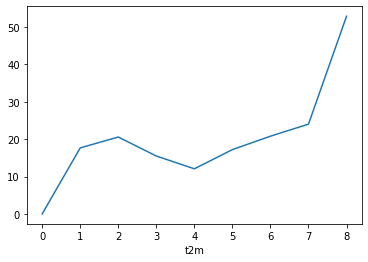

In [208]:
(df1b.groupby('t2m')['timestamp_dt'].nunique()/60).plot()

In [190]:
df1b['dt_1m'] = df1b['timestamp_dt'].dt.ceil('T')

<AxesSubplot:xlabel='dt_1m'>

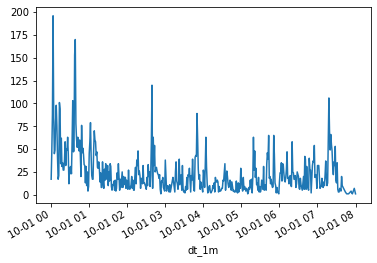

In [188]:
df1b.groupby('dt_1m')['timestamp_dt'].nunique().plot()

#### full order book update can be too noisy, check quote data

In [209]:
symbol = 'OPTIONS'
date = "2021-10-01"
data_type = "quotes" #"quotes"

In [210]:
t0 = time.time()
fname = 'deribit_{}_{}_{}.csv.gz'.format(data_type, date, symbol)
df = pd.read_csv(os.path.join(TARDIS_DATA_PATH, fname))
print_time_from_t0(t0)

5.75 sec


In [219]:
df1 = df.pipe(datautils.DeribitUtils.parse_symbol_col).pipe(datautils.DeribitUtils.parse_time_col).query('t2m<=168 and t2m>0')

'parse_symbol_col'  8.31 sec


In [223]:
df1.head(2)

,exchange,symbol,timestamp,local_timestamp,ask_amount,ask_price,bid_price,bid_amount,instrument,expire,strike,type,timestamp_dt,t2m
68,deribit,ETH-2OCT21-3600-C,1633046396120000,1633046400296144,12.0,0.0005,NaN,NaN,ETH,2021-10-02 08:00:00,3600.0,C,2021-09-30 23:59:56.120,33.0
72,deribit,ETH-2OCT21-3500-C,1633046396120000,1633046400297459,450.0,0.0005,NaN,NaN,ETH,2021-10-02 08:00:00,3500.0,C,2021-09-30 23:59:56.120,33.0


In [224]:
df2_btc_c = df1.query('instrument=="BTC" and type=="C"')

In [ ]:
for strike in sorted(list(df2_btc_c['strike'].unique())):
    #strike=44000
    print('strike=', strike)
    df2plot = df2_btc_c.query('strike==@strike').query('t2m<8')
    prices = sorted(list(df2plot['ask_price'].unique()))
    print('ask prices', prices)
    for price in prices:
        df2plot.query('ask_price==@price').groupby('timestamp_dt')['ask_amount'].max().plot()
    if len(prices)<13:
        plt.legend(prices)
    plt.show()

#### check quote data for futures

In [232]:
symbol = 'BTC-PERPETUAL'
date = "2021-10-01"
data_type = "quotes" #"quotes"

In [ ]:
t0 = time.time()
fname = 'deribit_{}_{}_{}.csv.gz'.format(data_type, date, symbol)
df = pd.read_csv(os.path.join(TARDIS_DATA_PATH, fname))
print_time_from_t0(t0)

0.94 sec


In [254]:
df1 = df.pipe(datautils.DeribitUtils.parse_futureSymbol_col).pipe(datautils.DeribitUtils.parse_time_col)

df1_btc = df1.query('instrument=="BTC"')

df1_btc['update'] = (df1_btc['ask_price'].diff()!=0) | (df1_btc['bid_price'].diff()!=0)

df1_btc['timestamp_dt_1h'] = df1_btc['timestamp_dt'].dt.ceil('H')

(df1_btc.groupby('timestamp_dt_1h')['update'].sum()/60).plot()

In [ ]:
symbol = 'BTC-PERPETUAL'
date = "2021-10-01"
data_type = "quotes" #"quotes"

In [ ]:
t0 = time.time()
fname = 'deribit_{}_{}_{}.csv.gz'.format(data_type, date, symbol)
df = pd.read_csv(os.path.join(TARDIS_DATA_PATH, fname))
print_time_from_t0(t0)

In [255]:
## analyze a list of dates for BTC PERP

In [270]:
symbol = 'BTC-PERPETUAL'
data_type = "quotes" #"quotes"
dates1 = pd.date_range(datetime(2021,1,1), datetime(2021,1,7))
dates2 = pd.date_range(datetime(2021,5,15), datetime(2021,5,21))


In [260]:
for date in dates1:
    date_str = date.strftime('%Y-%m-%d')
    fname = 'deribit_{}_{}_{}.csv.gz'.format(data_type, date_str, symbol)
    df = pd.read_csv(os.path.join(TARDIS_DATA_PATH, fname))
    

2021-01-02
2021-01-03
2021-01-04
2021-01-05
2021-01-06
2021-01-07
2021-01-08


In [263]:
df_combined2 = pd.concat([pd.read_csv(os.path.join(TARDIS_DATA_PATH,  'deribit_{}_{}_{}.csv.gz'.format(data_type, date.strftime('%Y-%m-%d'), symbol))) for date in dates2])

In [271]:
df_combined1 = pd.concat([pd.read_csv(os.path.join(TARDIS_DATA_PATH,  'deribit_{}_{}_{}.csv.gz'.format(data_type, date.strftime('%Y-%m-%d'), symbol))) for date in dates1])

'parse_futureSymbol_col'  3.26 sec


<AxesSubplot:xlabel='timestamp_dt_1h'>

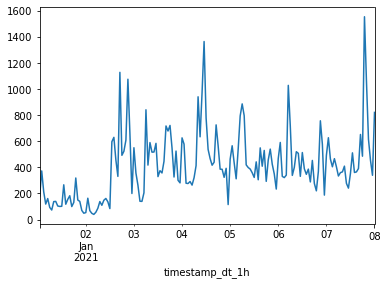

In [272]:
df1 = df_combined1.pipe(datautils.DeribitUtils.parse_futureSymbol_col).pipe(datautils.DeribitUtils.parse_time_col)

df1_btc = df1.query('instrument=="BTC"')

df1_btc['update'] = (df1_btc['ask_price'].diff()!=0) | (df1_btc['bid_price'].diff()!=0)

df1_btc['timestamp_dt_1h'] = df1_btc['timestamp_dt'].dt.ceil('H')

(df1_btc.groupby('timestamp_dt_1h')['update'].sum()/60).plot()